# **Import Packages**

In [ ]:
# !pip install plotly==5.4.0
# !pip install chart_studio

In [87]:
import os
import time
from tqdm.notebook import tqdm
from datetime import datetime, timedelta

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.pyplot import style
import plotly.offline as pyoff
import plotly.graph_objs as go

from My_code.Metrics import *

from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.model_selection import KFold, GridSearchCV
from catboost import CatBoostRegressor
import xgboost
from lightgbm import LGBMRegressor

style.use('seaborn-whitegrid')
os.getcwd()

'/Linux/[2021, 2022] 초분광(Hyperspectral) 데이터/[ 2022 ]/PSC'

# **함수**

## **_Train**

In [88]:
def HS_lag (data, lag_term = 3, before_y = "yes") :
    
    lag_data = data[["phycocyanin", "Year", "Month", "Day", "Hour", "Min"]]
    
    if before_y == "yes" :
        data2 = data.drop(columns = ["Year", "Month", "Day", "Hour", "Min"])
    else :
        data2 = data.drop(columns = ["phycocyanin", "Year", "Month", "Day", "Hour", "Min"])
    
    # lag_data 생성
    for i in range(1, lag_term+1) : 
        lag = data2.shift(i)
        lag.columns = lag.columns + "_lag_" + str(i)
        lag_data = pd.concat([lag_data, lag], axis = 1)

    lag_data = lag_data.iloc[lag_term :].reset_index(drop = True)  
    
    return lag_data

In [89]:
def HS_categorical (data) :

    ### 불필요한 변수 제거
    data = data.drop(columns = ["Year", "Day", "Min"])
    
    ### HS time from Hour -> "hs" or "non hs"
    morning = [10,11,12]   ;   afternoon = [13,14,15]   ;   evening = [16,17]
    
    x = data["Hour"].astype("int")
    condlist = [x.isin(morning), x.isin(afternoon), x.isin(evening)]
    choicelist = ["morning", "afternoon", "evening"]
    data["HS time"] = np.select(condlist, choicelist, "non-hs")
    data.drop(columns = "Hour", inplace = True)

    # HS time -> One-Hot encodint
    encode_hs_time = pd.get_dummies(data["HS time"], sparse = True)
    data = pd.concat([data.drop(columns = "HS time"), encode_hs_time], axis = 1)

    

    ### Season from Month -> "sprin, summer, fall, winter"
    spring = [3,4,5]   ;   summer = [6,7,8]   ;   fall = [9,10,11]
    
    y = data["Month"].astype("int")
    condlist = [y.isin(spring), y.isin(summer), y.isin(fall)]
    choicelist = ["spring", "summer", "fall"]
    data["season"] = np.select(condlist, choicelist, "winter")
    data.drop(columns = "Month", inplace = True)

    # Season -> One-Hot encodint
    encode_season = pd.get_dummies(data["season"], sparse = True)
    data = pd.concat([data.drop(columns = "season"), encode_season], axis = 1)


    # spring, summer, fall, winter 중 없는 변수 추가.
    season = ["spring", "summer", "fall", "winter"]
    for i in range(len(season)) :
        if season[i] not in data.columns :
            data[season[i]] = [0]*data.shape[0]

    return data

In [90]:
def HS_train (train_X, train_y, comp = 8) :
    
    ### 변수 구분
    category = ["spring", "summer", "fall", "winter", "morning", "afternoon", "evening", "non-hs"]
    category_X = train_X[category]
    reflec_X = train_X.filter(regex = "reflectance")
    other_X = train_X.drop(columns = (list(reflec_X.columns) + category))
    
    
    ### 표준화
    std_other = StandardScaler().fit(other_X)
    std_other_X = pd.DataFrame(std_other.transform(other_X), columns = other_X.columns).reset_index(drop = True)

    std_reflec = StandardScaler().fit(reflec_X)
    std_reflec_X = pd.DataFrame(std_reflec.transform(reflec_X), columns = reflec_X.columns).reset_index(drop = True)

    std_y = (train_y - train_y.mean())/train_y.std()


    ### PLS
    pls_fit = PLSRegression(n_components = comp).fit(std_reflec_X, std_y)
    pls_X = pd.DataFrame(pls_fit.transform(std_reflec_X), columns = ["comp" + str(i+1) for i in range(comp)]).reset_index(drop = True)

    new_train_X = pd.concat([std_other_X, pls_X, category_X], axis = 1)
    
    
    return {"new train X" : new_train_X, "pls" : pls_fit, "std other" : std_other, "std reflec" : std_reflec}    

In [91]:
def HS_model (data, MODEL, lag_term = 3, comp = 8, SEED = 999, before_y = "yes", hs = "yes") :
    
    lag_data = HS_lag(data, lag_term = lag_term, before_y = before_y)
    categorical_data = HS_categorical(lag_data)
    
    train_X = categorical_data.drop(["phycocyanin"], axis = 1)
    train_y = categorical_data["phycocyanin"]
    
    Train = HS_train(train_X, train_y, comp)
    
    new_train_X = Train["new train X"]
    if hs == "no" :
        new_train_X = new_train_X.drop(columns = new_train_X.filter(regex = "comp"))
        
    train_columns = new_train_X.columns
    train_pls = Train["pls"]
    train_std_other = Train["std other"]
    train_std_reflec = Train["std reflec"]
    
#     model = RandomForestRegressor(random_state = SEED).fit(new_train_X, np.ravel(train_y))
    model = MODEL.fit(new_train_X, np.ravel(train_y))
    

    return {"model" : model, "train pls" : train_pls, "train std other" : train_std_other, "train std reflec" : train_std_reflec, "train columns" : train_columns}

In [92]:
def HS_model_grid (data, MODEL, param_grid, lag_term = 3, comp = 8, SEED = 999, before_y = "yes") :
    
    lag_data = HS_lag(data, lag_term = lag_term, before_y = before_y)
    categorical_data = HS_categorical(lag_data)
    
    train_X = categorical_data.drop(["phycocyanin"], axis = 1)
    train_y = categorical_data["phycocyanin"]
    
    Train = HS_train(train_X, train_y, comp)
    
    new_train_X = Train["new train X"]
    train_columns = new_train_X.columns
    train_pls = Train["pls"]
    train_std_other = Train["std other"]
    train_std_reflec = Train["std reflec"]
    
    
    gcv = GridSearchCV(MODEL,      
                       param_grid = param_grid,  
                       cv = KFold(n_splits = 5, random_state = 999, shuffle = True),
                       scoring = "r2",
                       n_jobs = -1)

    gcv.fit(new_train_X, np.ravel(train_y))
 
    model = gcv.best_estimator_ 
    

    return {"model" : model, "train pls" : train_pls, "train std other" : train_std_other, "train std reflec" : train_std_reflec, "train columns" : train_columns}

## **_Test**

In [93]:
def HS_categorical_(data) :

    ### 불필요한 변수 제거
    data = data.drop(columns = ["Year", "Day", "Min"])
    
    ### HS time from Hour -> "hs" or "non hs"
    morning = [10,11,12]   ;   afternoon = [13,14,15]   ;   evening = [16,17]
    
    x = data["Hour"].astype("int")
    condlist = [x.isin(morning), x.isin(afternoon), x.isin(evening)]
    choicelist = ["morning", "afternoon", "evening"]
    data["HS time"] = np.select(condlist, choicelist, "non-hs")
    data.drop(columns = "Hour", inplace = True)

    # HS time -> One-Hot encodint
    encode_hs_time = pd.get_dummies(data["HS time"], sparse = True)
    data = pd.concat([data.drop(columns = "HS time"), encode_hs_time], axis = 1)
    

    ### Season from Month -> "sprin, summer, fall, winter"
    spring = [3,4,5]   ;   summer = [6,7,8]   ;   fall = [9,10,11]
    
    y = data["Month"].astype("int")
    condlist = [y.isin(spring), y.isin(summer), y.isin(fall)]
    choicelist = ["spring", "summer", "fall"]
    data["season"] = np.select(condlist, choicelist, "winter")
    data.drop(columns = "Month", inplace = True)

    # Season -> One-Hot encodint
    encode_season = pd.get_dummies(data["season"], sparse = True)
    data = pd.concat([data.drop(columns = "season"), encode_season], axis = 1)


    # afternoon, evening, morning, non-hs 중 없는 변수 추가
    time = ["afternoon", "evening", "morning", "non-hs"]
    for j in range(len(time)):
        if time[j] not in data.columns:
            data[time[j]] = [0]*data.shape[0]
                
    # spring, summer, fall, winter 중 없는 변수 추가.
    season = ["spring", "summer", "fall", "winter"]
    for i in range(len(season)) :
        if season[i] not in data.columns :
            data[season[i]] = [0]*data.shape[0]

    return data

In [94]:
### 최근 3개 데이터를 이름 붙여 리스트화
def lag_split_(data, lag_term = 3):
    split = []
    for j in range(lag_term):
        globals()["lag_{}".format(j)] = data.iloc[-j]
        split.append(globals()["lag_{}".format(j)])
    return split

In [95]:
### 변수 이름에 lag_{i} 붙이는 함수
def rename(data, lag_term):
    re_split = []
    for i in range(lag_term):
        data[i] = data[i].add_suffix("_lag{}".format(i))
        re_split.append(data[i])
    
    return data

In [96]:
### 데이터 프레임용 변수 이름
def column_set(data, lag_term = 3):
    col_list = []
    for i in range(lag_term):
        col = data.columns + "_lag_" + str(i+1)
        col_list += list(col.values)
    return col_list

In [97]:
### 최근 3개의 데이터를 lag data화
def testlag_(dataset, last_data, lag_term, before_y = "yes"):
    
    if before_y != "yes" :
        dataset = dataset.drop(columns = ['phycocyanin'])
    else :
        pass
    
    lag_data = pd.DataFrame()
    
    dataset = dataset.iloc[-lag_term:, :]
    dataset_ = dataset.iloc[:, 6:]

    split = lag_split_(dataset, lag_term = lag_term)
    re_split = rename(split, lag_term = lag_term)
    col_list = column_set(dataset, lag_term = lag_term)

    fin_data = pd.DataFrame(np.array(re_split).reshape(-1,1).T, columns = col_list)
    date = column_set(last_data.iloc[:, :5], lag_term = lag_term)
    fin_data = fin_data[fin_data.columns.drop(list(fin_data.filter(items = date)))]
    fin_data = pd.concat([last_data.iloc[:, :5] ,fin_data], axis = 1)
        
    now2 = datetime(last_data.iloc[[0]]["Year"], last_data.iloc[[0]]["Month"], last_data.iloc[[0]]["Day"], last_data.iloc[[0]]["Hour"], last_data.iloc[[0]]["Min"])
    now3 = now2 + timedelta(minutes = 15)
    future_time = [now3.year, now3.month, now3.day, now3.hour, now3.minute]
    now_time = pd.DataFrame(future_time, index = ['Year', 'Month', 'Day', 'Hour', 'Min']).T
        
    fin_data = pd.concat([now_time, fin_data.iloc[:, 5:]], axis = 1)
    fin_data = fin_data.iloc[[0],:]    
        
    return fin_data

In [98]:
### lag data를 Train 정보를 통해 변형
def prep_data_with_y(data, train_pls, train_std_other, train_std_reflec, hs = "yes"):
    
    data = HS_categorical_(data)

    weather_ = data.iloc[:, -8:]
    pls_fit = train_pls
    reflect_data = data.filter(regex = 'reflectance')
    
    std_reflec = train_std_reflec
    std_reflect_X = pd.DataFrame(std_reflec.transform(reflect_data), columns = reflect_data.columns).reset_index(drop = True)

    pls_X = pd.DataFrame(pls_fit.transform(reflect_data.to_numpy()), columns = ['comp' + str(i + 1) for i in range(8)]).reset_index(drop = True)
    
    ### weather, water std(std)   
    std_other = train_std_other
    other_ = data[data.columns.drop(list(data.filter(regex = 'reflectance')))]
    t_list = ["afternoon", "evening", "morning", "non-hs", "spring", "summer", "fall", "winter"]
    other_X = other_[other_.columns.drop(list(other_.filter(items = t_list)))]
    
    std_other_X = pd.DataFrame(std_other.transform(other_X.to_numpy()), columns = other_X.columns).reset_index(drop = True)

    test_dataset = pd.concat([pls_X, std_other_X, weather_], axis = 1)
    if hs == "no" :
        test_dataset = test_dataset.drop(columns = test_dataset.filter(regex = "comp"))

    return test_dataset

# **Model pipeline**

In [99]:
data = pd.read_csv("../DAT/complete_data(haman).csv")
data = data.fillna(0)

In [100]:
condlist = [((data["Month"] == 5) & (data["Day"] >= 23)), ((data["Month"] == 6) & (data["Day"] <= 8))]
choicelist = [1, 1]
use = np.select(condlist, choicelist).astype("int")
data["use"] = use

In [101]:
data_ = data[data["use"] == 1]
data_.drop(columns = ["use"], inplace = True)
data_.reset_index(drop = True, inplace = True)
data_

,Year,Month,Day,Hour,Min,chlorophyll,conductivity,do,ph,phycocyanin,...,reflectance.541,reflectance.542,reflectance.543,reflectance.544,reflectance.545,reflectance.546,reflectance.547,reflectance.548,reflectance.549,reflectance.550
0,2022,5,23,0,0,7.29,377.99,11.93,8.728,0.26,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2022,5,23,0,15,18.72,377.76,11.96,8.730,0.29,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2022,5,23,0,30,7.44,378.67,11.86,8.703,0.23,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2022,5,23,0,45,9.72,378.83,11.81,8.703,0.19,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2022,5,23,1,0,13.71,378.81,11.89,8.719,0.20,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1627,2022,6,8,22,45,9.15,350.19,10.81,8.549,0.17,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1628,2022,6,8,23,0,7.18,350.05,10.76,8.538,0.15,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1629,2022,6,8,23,15,4.68,349.83,10.82,8.536,0.27,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1630,2022,6,8,23,30,5.31,349.17,10.82,8.534,0.51,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


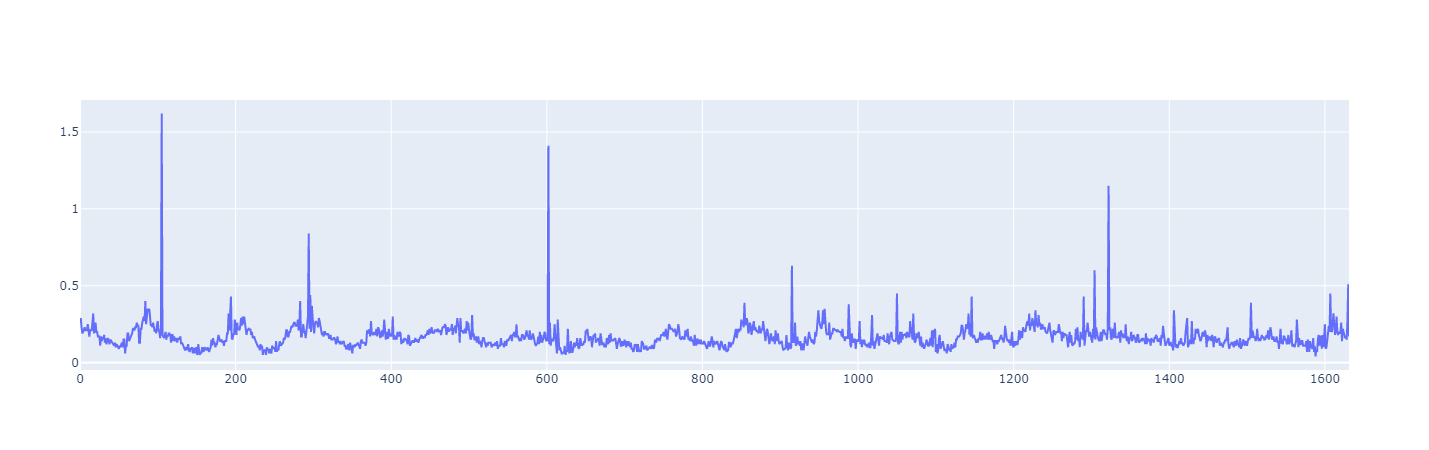

In [102]:
go.Figure(data = go.Scatter(y = data_["phycocyanin"], x = data_.index, mode='lines'))

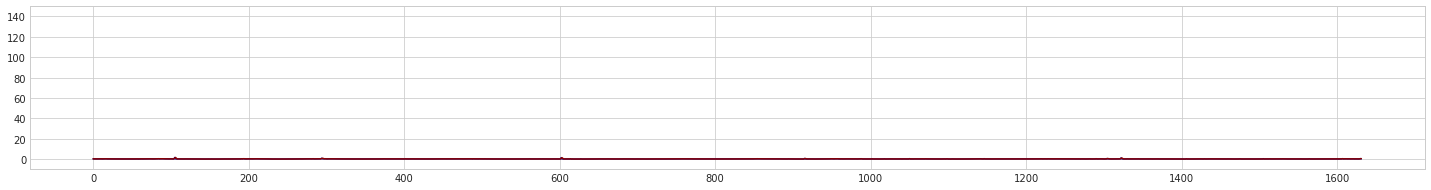

In [103]:
y_ = list(data_["phycocyanin"])
y__ = [y_[0]]

for i in range(0, len(y_)-1) :

#     if (abs(y_[i] - y_[i-1]) > 50) or (y_[i] < 1) :
    if y_[i] <= 0.5 :
        y_imp = (y_[i-1]+y_[i+1])/2
        y__.append(y_imp) 
    else :
        y__.append(y_[i]) 
        
plt.figure(figsize = (25,3))
plt.plot(data_["phycocyanin"].reset_index(drop = True), color = "darkblue")
plt.plot(y__, color = "darkred")
plt.ylim(-10, 150);

In [104]:
data__ = data_.copy()
data__["phycocyanin"] = y__
# data__

In [105]:
data_train = data_[(data_["Month"] != 6) & (data_["Day"] != 7)].reset_index(drop=True)
data_test = data_[(data_["Month"] == 6) & (data_["Day"] == 7)].reset_index(drop=True)

print(data_train.shape, data_test.shape)

(864, 569) (96, 569)


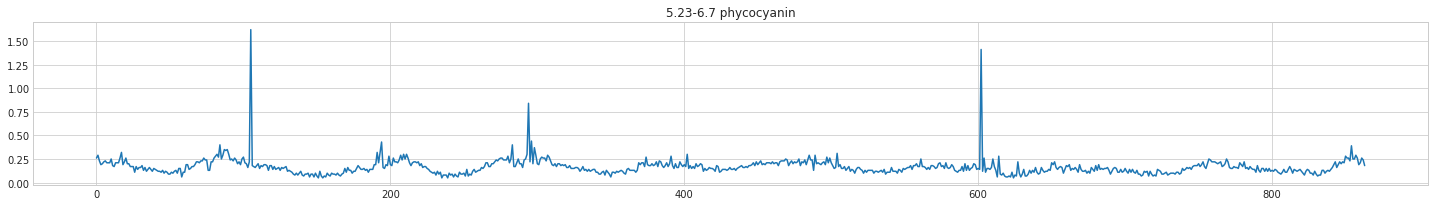

In [106]:
plt.figure(figsize = (25,3))
plt.plot(data_train["phycocyanin"])
plt.title("5.23-6.7 phycocyanin");

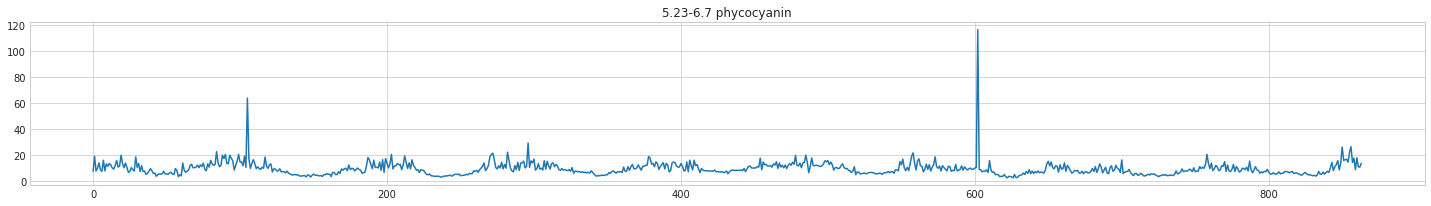

In [114]:
plt.figure(figsize = (25,3))
plt.plot(data_train["chlorophyll"])
plt.title("5.23-6.7 phycocyanin");

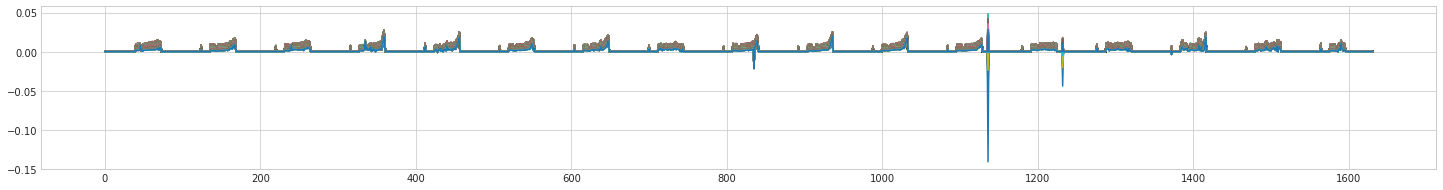

In [117]:
plt.figure(figsize = (25,3))
aa = data__.filter(regex = "reflectance")
plt.plot(aa[200:300]);

In [126]:
c = data__["chlorophyll"]*0.001
aa["c"] = c
aa

,reflectance.000,reflectance.001,reflectance.002,reflectance.003,reflectance.004,reflectance.005,reflectance.006,reflectance.007,reflectance.008,reflectance.009,...,reflectance.542,reflectance.543,reflectance.544,reflectance.545,reflectance.546,reflectance.547,reflectance.548,reflectance.549,reflectance.550,c
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00729
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01872
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00744
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00972
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01371
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1627,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00915
1628,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00718
1629,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00468
1630,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00531


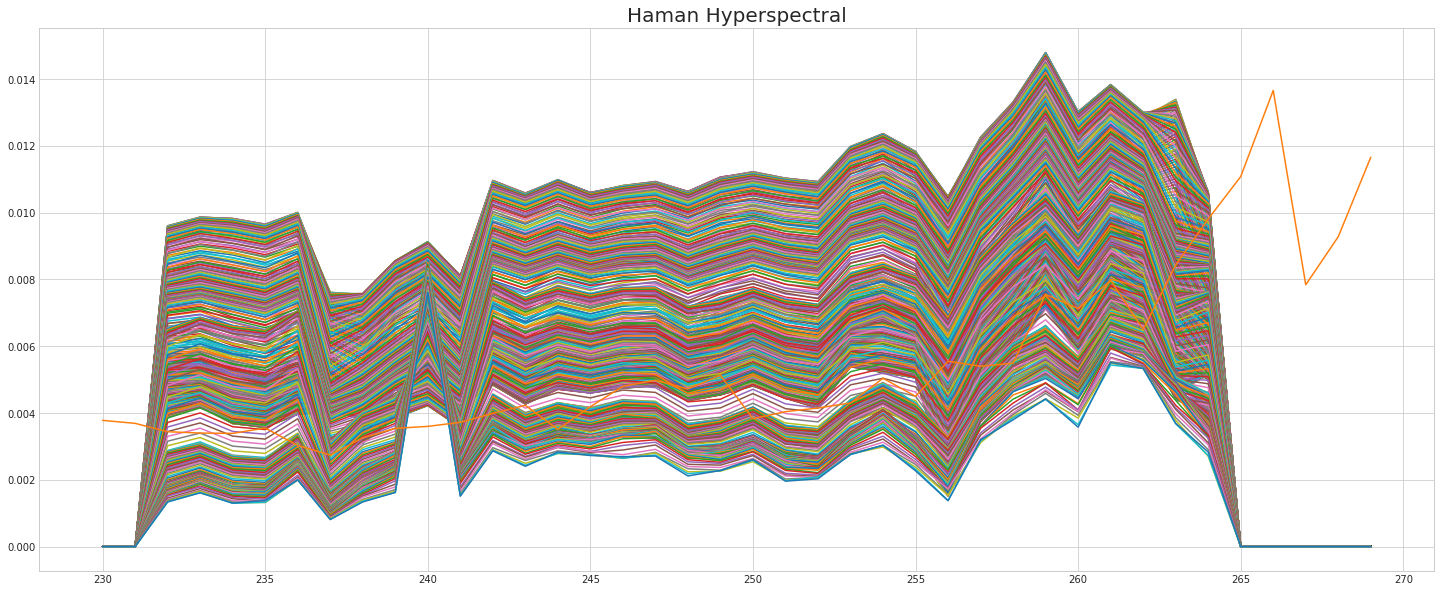

In [130]:
plt.figure(figsize = (25,10))
plt.plot(aa[230:270])
plt.title("Haman Hyperspectral", fontsize = 20);

In [107]:
parameters = {'max_depth': list(range(1, 21, 5)), 
              'min_samples_leaf': list(range(1, 6, 2)), 
              'min_samples_split':list(range(1, 6, 2)), 
              'n_estimators': list(range(100, 200, 20))}

In [108]:
import warnings
warnings.filterwarnings('ignore')

### 데이터가 쌓일 공간
dataset = data_train.copy()

### 기본 설정
lag_term = 3
Random_state = 717
before_y = "no"
hs = "no"
# MODELS = [RandomForestRegressor(random_state = Random_state), ExtraTreesRegressor(random_state = Random_state), AdaBoostRegressor(random_state = Random_state), xgboost.XGBRegressor(random_state = Random_state), 
#           GradientBoostingRegressor(random_state = Random_state), LGBMRegressor(random_state = Random_state), CatBoostRegressor(random_state = Random_state, verbose = 0)]
MODELS = [RandomForestRegressor(random_state = Random_state), xgboost.XGBRegressor(random_state = Random_state), LGBMRegressor(random_state = Random_state)]


### 기본 모델
model = HS_model(data_train, MODEL = GradientBoostingRegressor(random_state = Random_state), lag_term = lag_term)["model"]
print(model)


### 예측 과정
preds = []
pred_X_df = pd.DataFrame()
for i in tqdm(range(data_test.shape[0])) :
    
    dataset = dataset.append(data_test.iloc[[i]])
    last_data = dataset.iloc[[-1]]
    
    """ 매 0시0분 Model Update """
    if (last_data["Hour"].values == 0) & (last_data["Min"].values == 0) :
        print("\033[31m" +"%d년 %d월 %d일 %d시 %d분 Model Update 수행합니다." % (last_data["Year"], last_data["Month"], last_data["Day"], last_data["Hour"], last_data["Min"]) + "\033[0m")
        
        start_time = time.time()
        
        hs_models, models = [], []
        for j in range(len(MODELS)) :
            hs_model = HS_model(dataset, MODEL = MODELS[j], lag_term = lag_term, before_y = before_y, hs = hs)
            hs_models.append(hs_model)
            models.append(hs_model["model"])

        train_pls = hs_models[0]["train pls"]
        train_std_other = hs_models[0]["train std other"]
        train_std_reflec = hs_models[0]["train std reflec"]
        train_columns = hs_models[0]["train columns"]
        
        end_time = time.time()
        print("%.3f 경과시간" % (np.round(end_time- start_time, 3)))

        
    else :
        pass
    
    """ Prediction """
    pred_X = testlag_(dataset, last_data, lag_term = lag_term, before_y = before_y)
    pred_X = prep_data_with_y(pred_X, train_pls, train_std_other, train_std_reflec, hs = hs)
    pred_X = pred_X[train_columns]
    pred_X_df = pd.concat([pred_X_df, pred_X], axis = 0)    
    
    pred_list = []
    for j in range(len(models)) :
        pred_ = models[j].predict(pred_X)[0]
        pred_list.append(pred_)
        
    pred = np.mean(pred_list)
    
    preds.append(pred)   
    
    if i%50 == 0 :
        print("%d년 %d월 %d일 %d시 %d분 + 15분 후 예측값 : %.4f" % (last_data["Year"], last_data["Month"], last_data["Day"], last_data["Hour"], last_data["Min"], pred))

GradientBoostingRegressor(random_state=717)


  0%|          | 0/96 [00:00<?, ?it/s]

2022년 6월 7일 0시 0분 Model Update 수행합니다.
1.999 경과시간
2022년 6월 7일 0시 0분 + 15분 후 예측값 : 0.2652
2022년 6월 7일 12시 30분 + 15분 후 예측값 : 0.2043


R-square(OLS) :  0.051
R-square(sklearn) :  -4.432
Correlation :  0.226
MAPE :  61.568


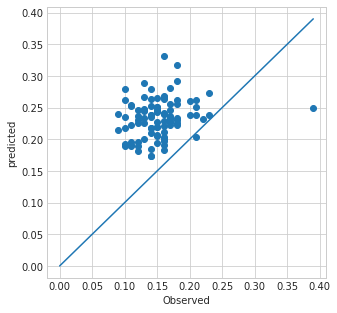

In [109]:
observed = list(data_test.loc[1:, "phycocyanin"].reset_index(drop = True))
preds2 = preds[:-1]

print("R-square(OLS) : ", R2_OLS(observed, preds2))
print("R-square(sklearn) : ", np.round(r2_score(observed, preds2), 3))
print("Correlation : ", np.round(np.corrcoef(observed, preds2)[0,1], 3))
print("MAPE : ", MAPE(observed, preds2))

plt.figure(figsize = (5,5))
plt.scatter(observed, preds2)
plt.xlabel("Observed") ; plt.ylabel("predicted")
plt.plot([0, max(max(observed), max(preds2))], [0, max(max(observed), max(preds2))]);

In [110]:
# display(data_test.head(2))
# display(data_test.tail(2))

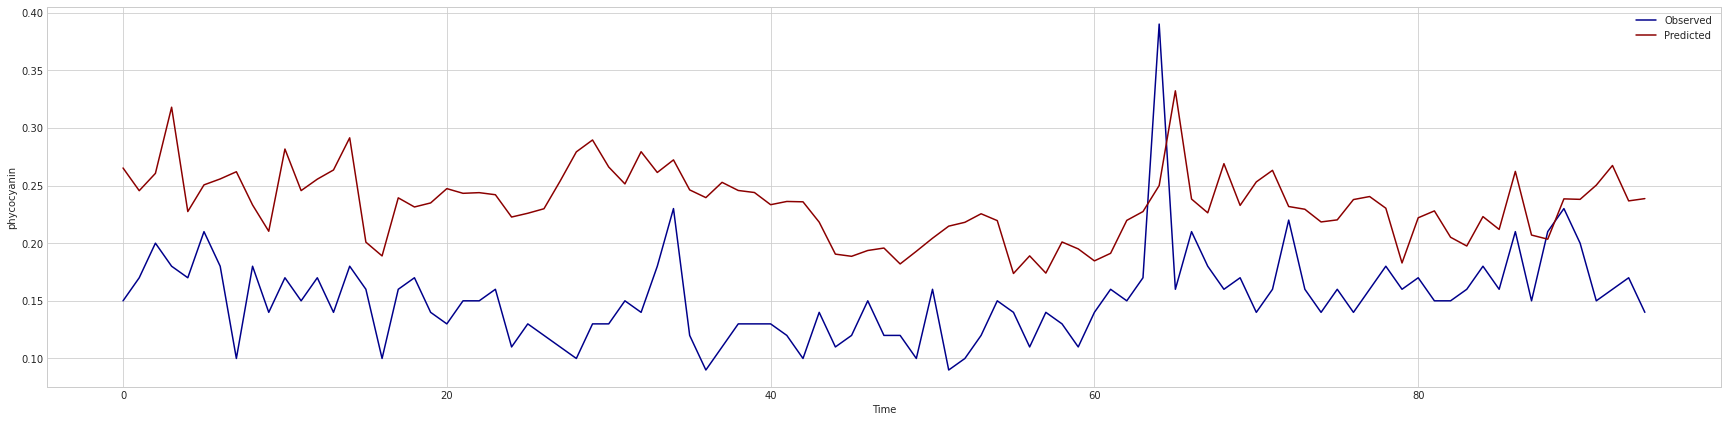

In [111]:
plt.figure(figsize = (30, 7))
plt.plot(observed, color = "darkblue", label = "Observed")
plt.plot(preds2, color = "darkred", label = "Predicted")
plt.xlabel("Time") ; plt.ylabel("phycocyanin")

plt.legend();

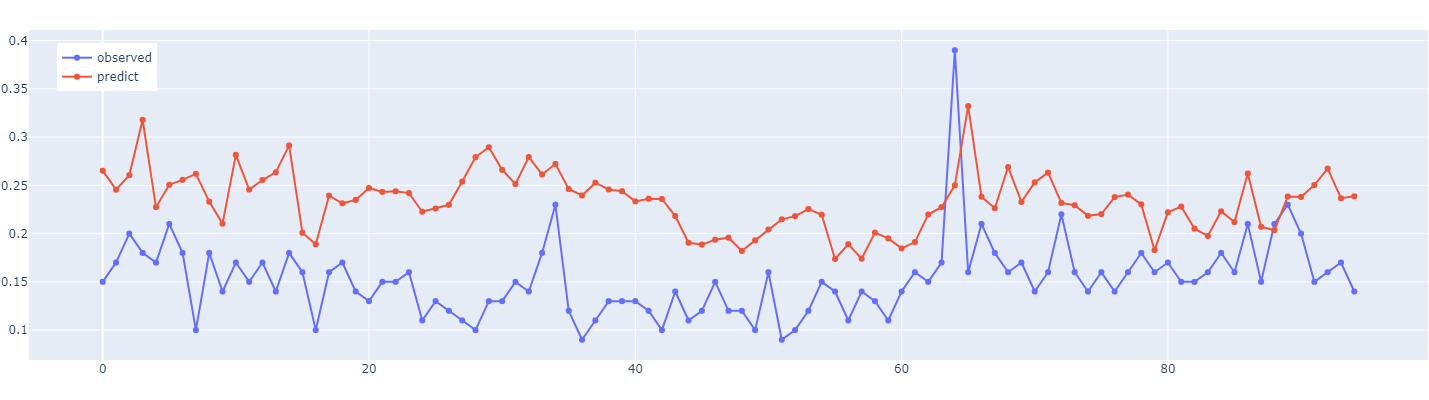

In [112]:
fig = go.Figure()
fig.update_layout(width = 1450, height = 400, margin = dict(l = 1, r = 1, t = 30, b = 40),
                  legend = dict(yanchor='top', y=0.96, xanchor='left', x=0.02))
fig.add_trace(go.Scatter(y = observed, x = list(range(len(observed))), mode = 'lines+markers', name = "observed"))
fig.add_trace(go.Scatter(y = preds2, x = list(range(len(preds2))), mode = 'lines+markers', name = "predict"))
fig.show();